In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
dat = pd.read_csv('data/data.csv', low_memory=False)

## Subset 31 questions & process data

In [3]:
# Define all index ranges and individual indices
mental_ix  = list(range(25, 30)) + [83, 105]
home_ix    = list(range(88, 91)) + list(range(98, 102)) + [103]
social_ix  = [13, 15, 18] + list(range(19, 25)) + [87, 102, 104]
health_ix  = list(range(75, 78)) + [84]

# Combine and sort unique indices
all_indices = sorted(set(mental_ix + home_ix + social_ix + health_ix))

# Subset columns by index
dat1 = dat.iloc[:, all_indices].copy()

In [4]:
num_rows_with_na = dat1.isna().any(axis=1).sum()
num_rows_with_na

np.int64(10900)

In [5]:
dat_cleaned = dat1.dropna(axis=0, how='any')
dat_cleaned.shape

(9203, 31)

In [6]:
dat_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9203 entries, 1 to 11426
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q14     9203 non-null   float64
 1   Q16     9203 non-null   float64
 2   Q19     9203 non-null   float64
 3   Q20     9203 non-null   float64
 4   Q21     9203 non-null   float64
 5   Q22     9203 non-null   float64
 6   Q23     9203 non-null   float64
 7   Q24     9203 non-null   float64
 8   Q25     9203 non-null   float64
 9   Q26     9203 non-null   float64
 10  Q27     9203 non-null   float64
 11  Q28     9203 non-null   float64
 12  Q29     9203 non-null   float64
 13  Q30     9203 non-null   float64
 14  Q76     9203 non-null   float64
 15  Q77     9203 non-null   float64
 16  Q78     9203 non-null   float64
 17  Q84     9203 non-null   float64
 18  Q85     9203 non-null   float64
 19  Q88     9203 non-null   float64
 20  Q89     9203 non-null   float64
 21  Q90     9203 non-null   float64
 22  Q91 

In [7]:
dat_cleaned = dat_cleaned.astype(int)

### Recode necessary columns

In [8]:
def binary_recode(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = df[col].apply(lambda x: 1 if x == 1 else 0)
    return df

In [9]:
def reverse_recode(df, cols):
    df = df.copy()
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = (max_val + min_val) - df[col]
    return df

In [10]:
# Binary: 1.0 = Yes → 1, 2.0 = No → 0
binary_cols = ['Q26', 'Q27', 'Q28', 'Q106', 'Q100', 'Q101', 'Q102', 'Q19', 'Q24', 'Q25', 'Q88', 'Q105']

# Ordinal: need to reverse
ordinal_cols = [                 
    'Q99', 'Q104',                
    'Q76', 'Q77', 'Q78',    
]

In [11]:
dat_final1 = binary_recode(dat_cleaned, binary_cols)
dat_final = reverse_recode(dat_final1, ordinal_cols)

In [12]:
dat_final['Q30'] = dat_final['Q30'].astype(int).map({1: 0, 3: 1, 2: 2})
dat_final['Q85'] = dat_cleaned['Q85'].astype(int).map({
    1: 3,
    2: 2,
    3: 1,
    4: 0,
    5: 0,
    6: 0,
    7: 1
})

#### Checking to make sure the recode is applied correctly

In [13]:
# Binary recode

print(dat_cleaned['Q27'].value_counts())
print(dat_final['Q27'].value_counts())

Q27
2    7143
1    2060
Name: count, dtype: int64
Q27
0    7143
1    2060
Name: count, dtype: int64


In [14]:
# Ordinal reverse recode

print(dat_cleaned['Q104'].value_counts())
print(dat_final['Q104'].value_counts())

Q104
5    4520
4    3299
3     792
2     362
1     230
Name: count, dtype: int64
Q104
1    4520
2    3299
3     792
4     362
5     230
Name: count, dtype: int64


In [15]:
# Special case 1 

print(dat_cleaned['Q30'].value_counts())
print(dat_final['Q30'].value_counts())

Q30
1    8290
3     717
2     196
Name: count, dtype: int64
Q30
0    8290
1     717
2     196
Name: count, dtype: int64


In [16]:
# Special case 2 (U recode)

print(dat_cleaned['Q85'].value_counts())
print(dat_final['Q85'].value_counts())

Q85
4    2550
3    2347
5    1533
2    1383
1     876
6     381
7     133
Name: count, dtype: int64
Q85
0    4464
1    2480
2    1383
3     876
Name: count, dtype: int64


## Subset the data per domain

In [17]:
# Create mapping of all_indices to relative positions
index_map = {orig_idx: i for i, orig_idx in enumerate(all_indices)}

# Remap each index list to match final data's column layout
mental_ix_local = [index_map[i] for i in mental_ix]
home_ix_local   = [index_map[i] for i in home_ix]
social_ix_local = [index_map[i] for i in social_ix]
health_ix_local = [index_map[i] for i in health_ix]

# Create combined index lists
home_context_ix   = mental_ix_local + home_ix_local
social_context_ix = mental_ix_local + social_ix_local
health_context_ix = mental_ix_local + health_ix_local

In [18]:
home_context = dat_final.iloc[:, home_context_ix].copy()
social_context = dat_final.iloc[:, social_context_ix].copy()
health_context = dat_final.iloc[:, health_context_ix].copy()

In [19]:
print(home_context.columns.tolist())
print(social_context.columns.tolist())
print(health_context.columns.tolist())


['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q89', 'Q90', 'Q91', 'Q99', 'Q100', 'Q101', 'Q102', 'Q104']
['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q14', 'Q16', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q88', 'Q103', 'Q105']
['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q84', 'Q106', 'Q76', 'Q77', 'Q78', 'Q85']


## Domain Specific Clustering


In [20]:
# Function to find the optimal number of clusters using the silhouette method


def find_optimal_k(X, max_k=6):
    sil_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        score = silhouette_score(X, kmeans.labels_)
        sil_scores.append(score)
    plt.plot(range(2, max_k + 1), sil_scores, marker='o')
    plt.title('Silhouette Score by k')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    return sil_scores.index(max(sil_scores)) + 2 

### Standardize the data


In [21]:
scaler = StandardScaler()

X_home = scaler.fit_transform(home_context)
X_social = scaler.fit_transform(social_context)
X_health = scaler.fit_transform(health_context)



### Home Environment 

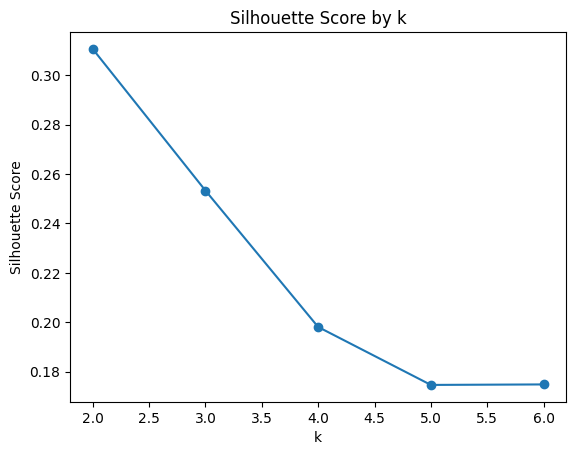

2

In [22]:
# find optimal k for home context
find_optimal_k(X_home)

In [23]:
kmeans_home = KMeans(n_clusters=2, random_state=123)
home_labels = kmeans_home.fit_predict(X_home)

# append the cluster labels to the 31Q dataset 
dat_final['HomeCluster'] = home_labels


### Social Environment 

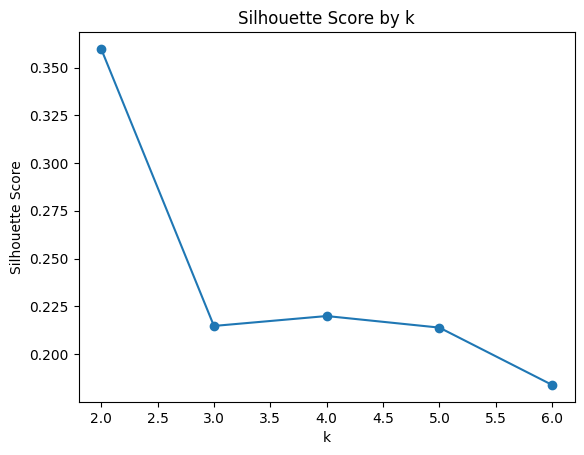

2

In [24]:
# find optimal k for home context
find_optimal_k(X_social)

In [25]:
kmeans_social = KMeans(n_clusters=2, random_state=123)
social_labels = kmeans_social.fit_predict(X_social)

# append the cluster labels to the 31Q dataset 
dat_final['SocialCluster'] = social_labels

### Phyiscal Health 

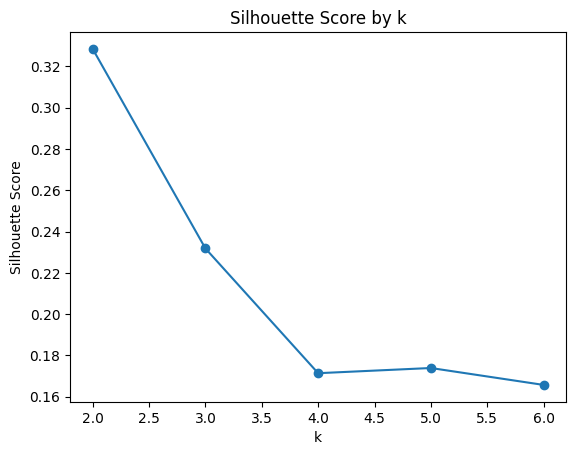

2

In [26]:
# find optimal k for home context
find_optimal_k(X_health)

In [27]:
kmeans_health= KMeans(n_clusters=2, random_state=123)
health_labels = kmeans_health.fit_predict(X_health)

# append the cluster labels to the 31Q dataset 
dat_final['HealthCluster'] = health_labels

### Analyze and Compare the Clusters


In [28]:
pd.crosstab(dat_final['HomeCluster'], dat_final['SocialCluster'])

SocialCluster,0,1
HomeCluster,,
0,838,1782
1,6384,199


In [29]:
pd.crosstab(dat_final['HomeCluster'], dat_final['HealthCluster'])

HealthCluster,0,1
HomeCluster,,
0,1868,752
1,164,6419


In [30]:
pd.crosstab(dat_final['SocialCluster'], dat_final['HealthCluster'])

HealthCluster,0,1
SocialCluster,,
0,353,6869
1,1679,302


# Working with Full Dataset

#### Data Exploration

In [31]:
# Count missing values per column
missing_summary = dat.isnull().sum().sort_values(ascending=False)

# Percentage missing per column
missing_pct = (dat.isnull().mean() * 100).sort_values(ascending=False)

# Preview top 10 most missing
print(missing_summary.head(10))
print(missing_pct.head(10))

QN34        19580
QN37        17457
QN45        17077
QNDUALBC    16659
QNBCNONE    16614
QNOTHHPL    16614
QNIUDIMP    16614
QN62        16614
QN60        16526
QN61        16194
dtype: int64
QN34        97.398398
QN37        86.837785
QN45        84.947520
QNDUALBC    82.868229
QNBCNONE    82.644381
QNOTHHPL    82.644381
QNIUDIMP    82.644381
QN62        82.644381
QN60        82.206636
QN61        80.555141
dtype: float64


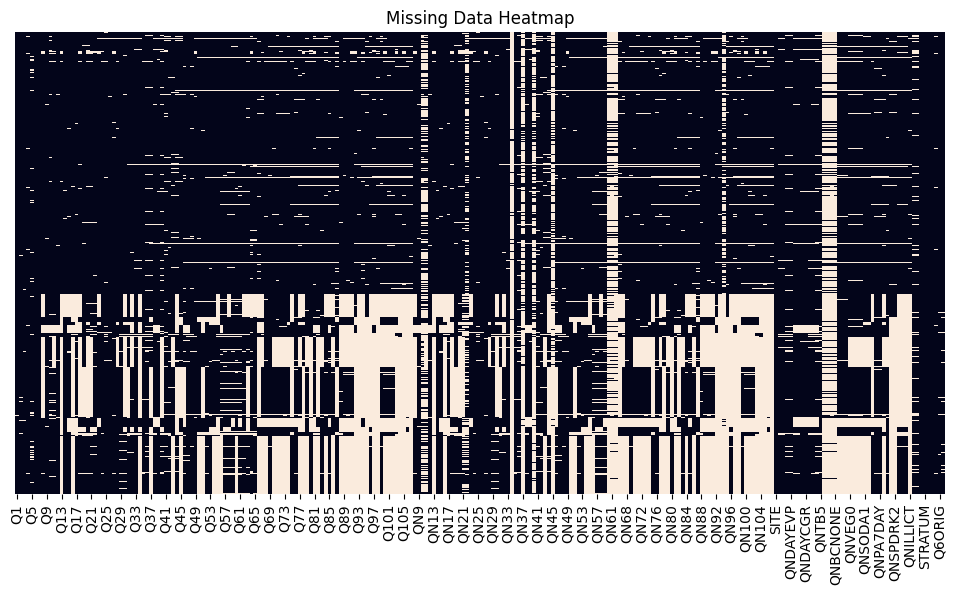

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(dat.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()

In [33]:
# Calculate percentage missing per column
missing_pct = dat.isnull().mean() * 100

# Filter columns with >50% missing
high_missing = missing_pct[missing_pct > 50].sort_values(ascending=False)

# Display them
print(f"{len(high_missing)} columns have more than 50% missing:\n")
print(high_missing)

14 columns have more than 50% missing:

QN34        97.398398
QN37        86.837785
QN45        84.947520
QNDUALBC    82.868229
QN62        82.644381
QNIUDIMP    82.644381
QNOTHHPL    82.644381
QNBCNONE    82.644381
QN60        82.206636
QN61        80.555141
QN40        78.426106
QN94        72.680694
QN11        59.861712
QN10        57.339701
dtype: float64


In [34]:
# Calculate percentage missing per column
missing_pct = dat.isnull().mean() * 100

# Filter columns with >40% missing
high_missing = missing_pct[missing_pct > 40].sort_values(ascending=False)

# Display them
print(f"{len(high_missing)} columns have more than 50% missing:\n")
print(high_missing)

43 columns have more than 50% missing:

QN34        97.398398
QN37        86.837785
QN45        84.947520
QNDUALBC    82.868229
QNBCNONE    82.644381
QNOTHHPL    82.644381
QNIUDIMP    82.644381
QN62        82.644381
QN60        82.206636
QN61        80.555141
QN40        78.426106
QN94        72.680694
QN11        59.861712
QN10        57.339701
Q105        47.356116
QN105       47.356116
QN98        46.336368
Q98         46.336368
Q107        46.301547
QN107       46.301547
Q104        46.027956
QN104       46.027956
QNILLICT    45.654877
Q106        45.550415
QN106       45.550415
Q93         44.431179
QN93        44.431179
Q103        44.401333
QN103       44.401333
Q97         44.301845
QN97        44.301845
Q94         43.625330
Q13         43.421380
QN13        43.421380
QN22        42.759787
QN16        42.038502
Q16         42.038502
QN66        41.327165
Q66         41.327165
QN95        40.760086
Q95         40.760086
QNSPDRK1    40.760086
QNSPDRK2    40.760086
dtype: float64

#### Missingness and Dropping QN# and QNword columns

In [35]:
# Step 1: Drop all QN# and QNword columns
qn_cols = [col for col in dat.columns if col.startswith('QN')]
dat2_step1 = dat.drop(columns=qn_cols)

# Step 2: Drop rows with any remaining missing values
dat2_cleaned = dat2_step1.dropna().copy()

print(f"Final shape of dat2_cleaned: {dat2_cleaned.shape}")

Final shape of dat2_cleaned: (6911, 115)


#### Recoding

•	Directional Binary\
•	Directional Reverse-Score (Ordinal)\
•	Neutral Numeric\
•	One-Hot\
•	Special Cases

14, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 76, 77, 78, 84, 85, 88, 89, 90, 91, 99, 100, 101, 102, 103, 104, 105, 106

In [ ]:
# Set working dataframe:
dat2_final = dat2_cleaned.copy()

# set as int


In [42]:
dat2_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6911 entries, 1 to 11426
Columns: 115 entries, Q1 to Q7ORIG
dtypes: float64(88), int64(19), object(8)
memory usage: 6.1+ MB


In [ ]:
# Binary
## Directional and Neutral Binary

binary_cols_dat2 = [
    'Q18', 'Q19', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q31',
    'Q35', 'Q88', 'Q100', 'Q101', 'Q102', 'Q105', 'Q106'
]

dat2_final = binary_recode(dat2_final, binary_cols_dat2)

In [38]:
# Directional - Ordinal
## Reverse-Score

ordinal_cols_dat2 = [
    'Q8', 'Q76', 'Q77', 'Q78', 'Q96', 'Q97', 'Q99', 'Q104'
]

dat2_final = reverse_recode(dat2_final, ordinal_cols_dat2)

In [40]:
# Neutral Numeric

def numeric_recode(df, neutral_cols):
    df = df.copy()
    for col in numeric_cols_dat2:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(int)
    return df

numeric_cols_dat2 = ['Q1', 'Q3']

dat2_final = numeric_recode(dat2_final, numeric_cols_dat2)